In [1]:
import tensorflow as tf

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if not os.path.isdir('models'):
    os.mkdir('models')
#this code cell ensures that there is a directory(folder) named 'models' in the path where the notebook is located
#this folder will contain all our models

In [4]:
print('TensorFlow version:', tf.__version__)
#version of tensorflow

TensorFlow version: 2.2.0


In [5]:
print('Is using GPU?',tf.test.is_gpu_available())
#is the pc using its gpu for processing data?

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


In [8]:
def get_three_classes(x, y, classes):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices
    
    assert len(classes) == 3
    
    idx1, idx2, idx3 = classes
    indices = np.concatenate([indices_of(idx1), indices_of(idx2), indices_of(idx3)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    y = np.array([classes.index(label) for label in y])
    # Note: classes are changed from whatever they were to 0, 1, 2
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y, num_classes=3)
    
    return x, y

In [33]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train,y_train=get_three_classes(X_train,y_train,[4,5,6])
x_test,y_test=get_three_classes(X_test,y_test,[4,5,6])

In [34]:
# Loading the dataset
#cifar10 dataset consists of 60000 32*32 colour images in 10 classes,with 6000 images per class.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (15000, 3)
(10000, 32, 32, 3) (3000, 3)


What `get_three_classes()` is doing is that it is taking the whole cifar10 dataset and extracting only three types of images and concatenating them columnwise to form a new 4D array. then it is converitng those images
(which are of course 3 dimensional matrices each) into binary class matrix

## Visualising Examples

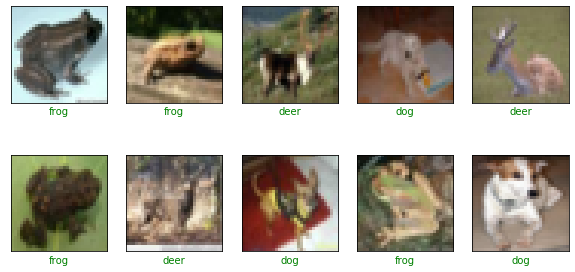

In [35]:
class_names=['deer','dog','frog']

def show_random_examples(x, y, p):
    indices=np.random.choice(range(x.shape[0]),10,replace=False)
    
    x=x[indices]
    y=y[indices]
    p=p[indices]
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    plt.show()
show_random_examples(x_train,y_train,y_train)

## Creating the Model

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout,Flatten,Input,Dense

In [15]:
def create_model():
    def add_conv_block(model,num_filters):
        model.add(Conv2D(num_filters,3,activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters,3,activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    model=tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    model=add_conv_block(model,32)
    model=add_conv_block(model,64)
    model=add_conv_block(model,128)
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [22]:
h=model.fit(
    x_train/255.,y_train,validation_data=(x_test/255.,y_test),
    epochs=10, batch_size=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                          save_best_only=True,save_weights_only=False,
                                          monitor='val_accuracy'
                                          )
    ]
           )

Epoch 1/10
150/150 [==============================] - 51s 342ms/step - loss: 0.7687 - accuracy: 0.6708 - val_loss: 1.6425 - val_accuracy: 0.5120
Epoch 2/10
150/150 [==============================] - 50s 330ms/step - loss: 0.5453 - accuracy: 0.7787 - val_loss: 0.5565 - val_accuracy: 0.7780
Epoch 3/10
150/150 [==============================] - 50s 330ms/step - loss: 0.4695 - accuracy: 0.8168 - val_loss: 0.5317 - val_accuracy: 0.7980
Epoch 4/10
150/150 [==============================] - 50s 332ms/step - loss: 0.4356 - accuracy: 0.8365 - val_loss: 0.5452 - val_accuracy: 0.8103
Epoch 5/10
150/150 [==============================] - 49s 329ms/step - loss: 0.3967 - accuracy: 0.8464 - val_loss: 0.7017 - val_accuracy: 0.7543
Epoch 6/10
150/150 [==============================] - 50s 334ms/step - loss: 0.3765 - accuracy: 0.8555 - val_loss: 0.4480 - val_accuracy: 0.8403
Epoch 7/10
150/150 [==============================] - 52s 344ms/step - loss: 0.3565 - accuracy: 0.8622 - val_loss: 0.3752 - val_ac

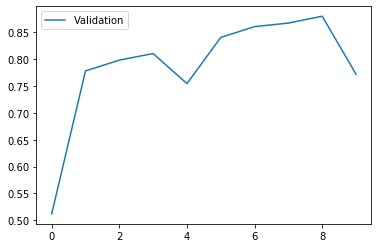

In [23]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']
plt.plot(range(len(accs)),val_accs, label='Validation')
plt.legend()
plt.show()

In [38]:
model=tf.keras.models.load_model('models/model_0.880.h5')


In [39]:
preds=model.predict(x_test/255.)

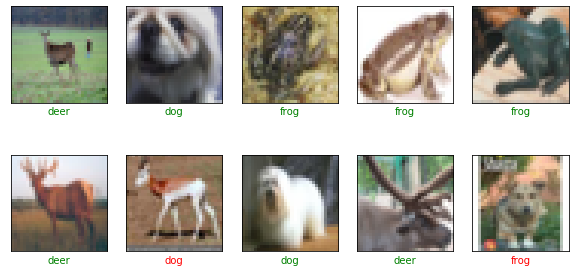

In [40]:
show_random_examples(x_test,y_test,preds)